# Phase III: First ML Proof of Concept (5\%)

### Team Names:
-
-
-

In [19]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
#load_dotenv() # comment this out if you aren't putting the api key in a .env

# If you don't feel like installing dotenv just replace the api-key stuff with: api_key = "your_api_key_here" and remove before commit pls
api_key = os.getenv('TRANSITLAND_API_KEY')

base_url = "https://transit.land/api/v2/rest/routes"

In [21]:
# cities and coordinates
cities = [
    {"name": "Boston", "bbox": "-71.191155,42.227926,-70.986166,42.400819"},
    {"name": "New York", "bbox": "-74.259090,40.477399,-73.700272,40.917577"},
    {"name": "Chicago", "bbox": "-87.940101,41.643919,-87.523985,42.023131"},
    {"name": "San Francisco", "bbox": "-122.515,37.703,-122.357,37.812"}
]

# empty dict for the transit info
transit_dict = {
    'city': [],
    'route_name': [],
    'route_type': [],  # categorical route type
    'route_id_numeric': [],  # numeric value of the routeID
    'route_sort_order': [] # numeric value of route order
}

def get_data_from_api():
    """
    Method to retrieve data from the API.
    It is no longer used regularly as we have moved the data to a csv.
    """

    for city in cities:
        all_routes = []
        cursor = None
        
        while True:
            params = {
                "bbox": city['bbox'], 
                "limit": 1000,
                "apikey": api_key
            }
            if cursor:
                params['after'] = cursor
            
            response = requests.get(base_url, params=params)
            data = response.json()
            
            routes = data.get('routes', [])
            if not routes:
                break
                
            all_routes.extend(routes)
            
            meta = data.get('meta', {}) # changed to check every page cause the data was pretty biased before
            cursor = meta.get('after')
            if not cursor:
                break
        
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # organize cols
        for route in all_routes:
            transit_dict['city'].append(city['name'])
            transit_dict['route_name'].append(route.get('route_long_name', route.get('route_short_name', 'Unknown')))
            
            # obtain categorical route type (0=tram, 1=subway, 2=rail, 3=bus, ...) to measure variability
            transit_dict['route_type'].append(route.get('route_type', 3))
            
            # obtain numeric value of the routeID
            route_id = route.get('id', 0)
            transit_dict['route_id_numeric'].append(route_id if isinstance(route_id, int) else hash(str(route_id)) % 10000)
            
            # obtain numeric value of route order, which notes priority of routes to measure efficiency
            transit_dict['route_sort_order'].append(route.get('route_sort_order', 999))

# get_data_from_api()
# transit_df = pd.DataFrame(transit_dict)

transit_df = pd.read_csv('transit_df.csv')
display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category
0,Boston,Alewife Shuttle Route A,3,145185,1.0,390,5,44.20582,Transit-Limited
1,Boston,Alewife Shuttle Route B,3,145186,2.0,390,5,44.20582,Transit-Limited
2,Boston,Alewife Shuttle Route C,3,145187,3.0,390,5,44.20582,Transit-Limited
3,Boston,Alewife Shuttle Route D,3,145188,4.0,390,5,44.20582,Transit-Limited
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0,390,5,44.20582,Transit-Limited
5,Boston,Hartwell Area Shuttle (PM),3,145190,6.0,390,5,44.20582,Transit-Limited
6,Boston,Commuter,3,15660215,1.0,390,5,44.20582,Transit-Limited
7,Boston,BOSTON LOGAN AIRPORT - NEWARK,3,51181250,0.0,390,5,44.20582,Transit-Limited
8,Boston,NEWARK - BOSTON LOGAN AIRPORT,3,51181251,0.0,390,5,44.20582,Transit-Limited
9,Boston,BOSTON SOUTH STATION - NEWARK,3,51181262,0.0,390,5,44.20582,Transit-Limited


In [22]:
# cleaning data
# lists unnamed routes as having an unknown name
transit_df['route_name'] = transit_df['route_name'].replace('', 'Unknown')
transit_df.loc[transit_df['route_name'].isna(), 'route_name'] = 'Unknown'\

# sets the route sor torder to a float and replaces any missing sort orders with 999
transit_df['route_sort_order'] = transit_df['route_sort_order'].fillna(999)
transit_df['route_sort_order'] = transit_df['route_sort_order'].astype(float)

# removes duplicate routes
transit_df = transit_df.drop_duplicates(subset=['city', 'route_id_numeric'], keep='first')

# makes all route types ints and replaces missing route types with 3
transit_df['route_type'] = transit_df['route_type'].fillna(3)
transit_df['route_type'] = transit_df['route_type'].astype(int)

# summarizes some the city statistics
city_summary = transit_df.groupby('city').agg({
    'route_id_numeric': 'count', # total number of routes in each city
    'route_type': 'nunique', # number of different types of transit
    'route_sort_order': 'mean' # average route priority, lower = more priority
}).reset_index()

# renames columns for the city summary
city_summary.columns = [
    'city',
    'total_routes',
    'route_type_diversity',
    'avg_route_priority'
]

# transit richness score
# 50% weight in number of cities
# 30% weight in the number of transit types
# 20% weight in the average priority
city_summary['transit_richness_score'] = (
    (city_summary['total_routes'] / city_summary['total_routes'].max() * 50) +
    (city_summary['route_type_diversity'] / city_summary['route_type_diversity'].max() * 30) +
    ((1 / (city_summary['avg_route_priority'] + 1)) / 
     (1 / (city_summary['avg_route_priority'] + 1)).max() * 20)
)

# classify cities by transit richness score
# above median = transit rich
# below median = transit limited
median_score = city_summary['transit_richness_score'].median()
city_summary['transit_category'] = city_summary['transit_richness_score'].apply(
    lambda x: 'Transit-Rich' if x >= median_score else 'Transit-Limited'
)

display(city_summary)

# merges the route data with the city summary
city_cols = ['city', 'total_routes', 'route_type_diversity', 'transit_richness_score', 'transit_category']
#transit_df_merged = transit_df.merge(city_summary[city_cols], on='city', how='left')

#transit_df_merged.to_csv('transit_df.csv', index=False)

#display(transit_df_merged.head(30))

,city,total_routes,route_type_diversity,avg_route_priority,transit_richness_score,transit_category
0,Boston,390,5,39314.679487,44.205820,Transit-Limited
1,Chicago,264,4,984.314394,50.172407,Transit-Limited
2,New York,1039,6,859.567854,100.000000,Transit-Rich
3,San Francisco,161,6,999.000000,54.959192,Transit-Rich


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np

### Attempt 1 - Linear Regression

In [24]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.
    
    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph
    
    Returns:
        An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse.round(3)}")
    r2 = 1 - (mse/y.var())
    print(f"{title} - R2: {r2.round(4)}")
    
    # Residuals
    residuals = y_test - y_pred
    
    # Diagnostic Plots
    plt.figure(figsize=(16, 12))
    
    # 1. Residuals vs Fitted (Linearity/Constant Variance)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residual plot vs Order")
        
    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')

    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [25]:
# Main function to answer the question
def main(): 
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """
    try:
        df = pd.read_csv('transit_df.csv')
        city_cols = ['city', 'total_routes', 'route_type_diversity', 'transit_richness_score', 'transit_category']
        #df = preprocess_data(df)
        
        # Model 1: City
        print("Model 1: City")
        X_time = df[['city']]
        y_time = df['total_routes']
        evaluate_model(X_time, y_time, "City Model")
        
        # Model 2: Cetegory
        print("Model 2: Category")
        df['member_casual'] = df['member_casual'].astype('category').cat.codes
        X_demo = df[['transit_category']]
        y_demo = df['total_routes']
        evaluate_model(X_demo, y_demo, "Category Model")
        
        # Model 3: Richness Score
        print("Model 3: Transit Richness Score")
        X_station = df[['transit_richness_score']]
        y_station = df['total_routes']
        evaluate_model(X_station, y_station, "Transit Richness Score Model")
    
    except FileNotFoundError:
        print(f"File not found: {'transit_df.csv'}")
    except ValueError as e:
        print(str(e))

# Run the main function
if __name__ == '__main__':
    main()

Model 1: City
could not convert string to float: 'New York'


### Attempt 2 - Polynomial regression

In [26]:
df = pd.read_csv('transit_df.csv')
df.head()

,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category
0,Boston,Alewife Shuttle Route A,3,145185,1.0,390,5,44.20582,Transit-Limited
1,Boston,Alewife Shuttle Route B,3,145186,2.0,390,5,44.20582,Transit-Limited
2,Boston,Alewife Shuttle Route C,3,145187,3.0,390,5,44.20582,Transit-Limited
3,Boston,Alewife Shuttle Route D,3,145188,4.0,390,5,44.20582,Transit-Limited
4,Boston,Hartwell Area Shuttle (AM),3,145189,5.0,390,5,44.20582,Transit-Limited


In [27]:
from sklearn.preprocessing import PolynomialFeatures

# prepare the data
X_route_type = np.array(df['route_type']).reshape(-1, 1)
y = np.log1p(df['route_sort_order'])

In [28]:
# degree 2 for polynomial regression (might change this later ngl)
poly = PolynomialFeatures(degree=2)
# gets the X_poly with bias column in the beginning
X_poly_bias = poly.fit_transform(X_route_type)
# removes the bias column
X_poly = X_poly_bias[:, 1:]
print("First polynomial feature vector:", X_poly[0])

First polynomial feature vector: [3. 9.]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function. 

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [29]:
def add_bias_column(X):
    """ adds a bias column
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [30]:
def line_of_best_fit(X, y):
    """ returns a vector containing the coefficients for the line of best fit, including an intercept term
    Args:
        X (array): either 1-d or 2-d which includes all the predictor values, not including bias term
        y (array): a 1-d array which includes all corresponding response values to X
        
    Returns:
        m (array): the vector containing the coefficients for the line of best fit, including an intercept term
    """
    # adds a bias column to X
    X_new = add_bias_column(X)
    # calculates the line of best fit
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

In [31]:
from sklearn.metrics import r2_score

In [32]:
def linreg_predict(Xnew, ynew, m):
    """ returns a dictionary containing: the predicted values from applying m to Xnew, the residuals, 
    the mean squared error, and the coefficient of determination

    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (array): a 1-d array of length which contains the coefficients from the line_of_best_fit function

    Returns:
        output_dict (dictionary): a dictionary that has:
            - 'ypreds' (the predicted values from applying m to Xnew)
            - 'resids' (the residuals, the differences between ynew and ypreds)
            - 'mse' (the mean squared error)
            - 'r2' (the coefficient of determination representing the proportion of variability in ynew explained by the line of best fit
    """
    # initializes an output dictionary for required values
    output_dict = {}
    # adds a bias column to the Xnew array
    Xnew_bias_added = add_bias_column(Xnew)
    # calculates the line of best fit for Xnew with bias and ynew
    # gets the predicted values from applying m to Xnew
    ypreds = np.matmul(Xnew_bias_added, m)
    # gets the residuals
    res = ynew - ypreds
    # gets the mean squared error
    mse = (res**2).mean()
    # gets the R^2
    r2 = r2_score(ynew, ypreds)
    # adds values to the dictionary
    output_dict['ypreds'] = ypreds
    output_dict['resids'] = res
    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

MSE for the polynomial regression model = 5.352
R^2 for the polynomial regression model = -0.0259


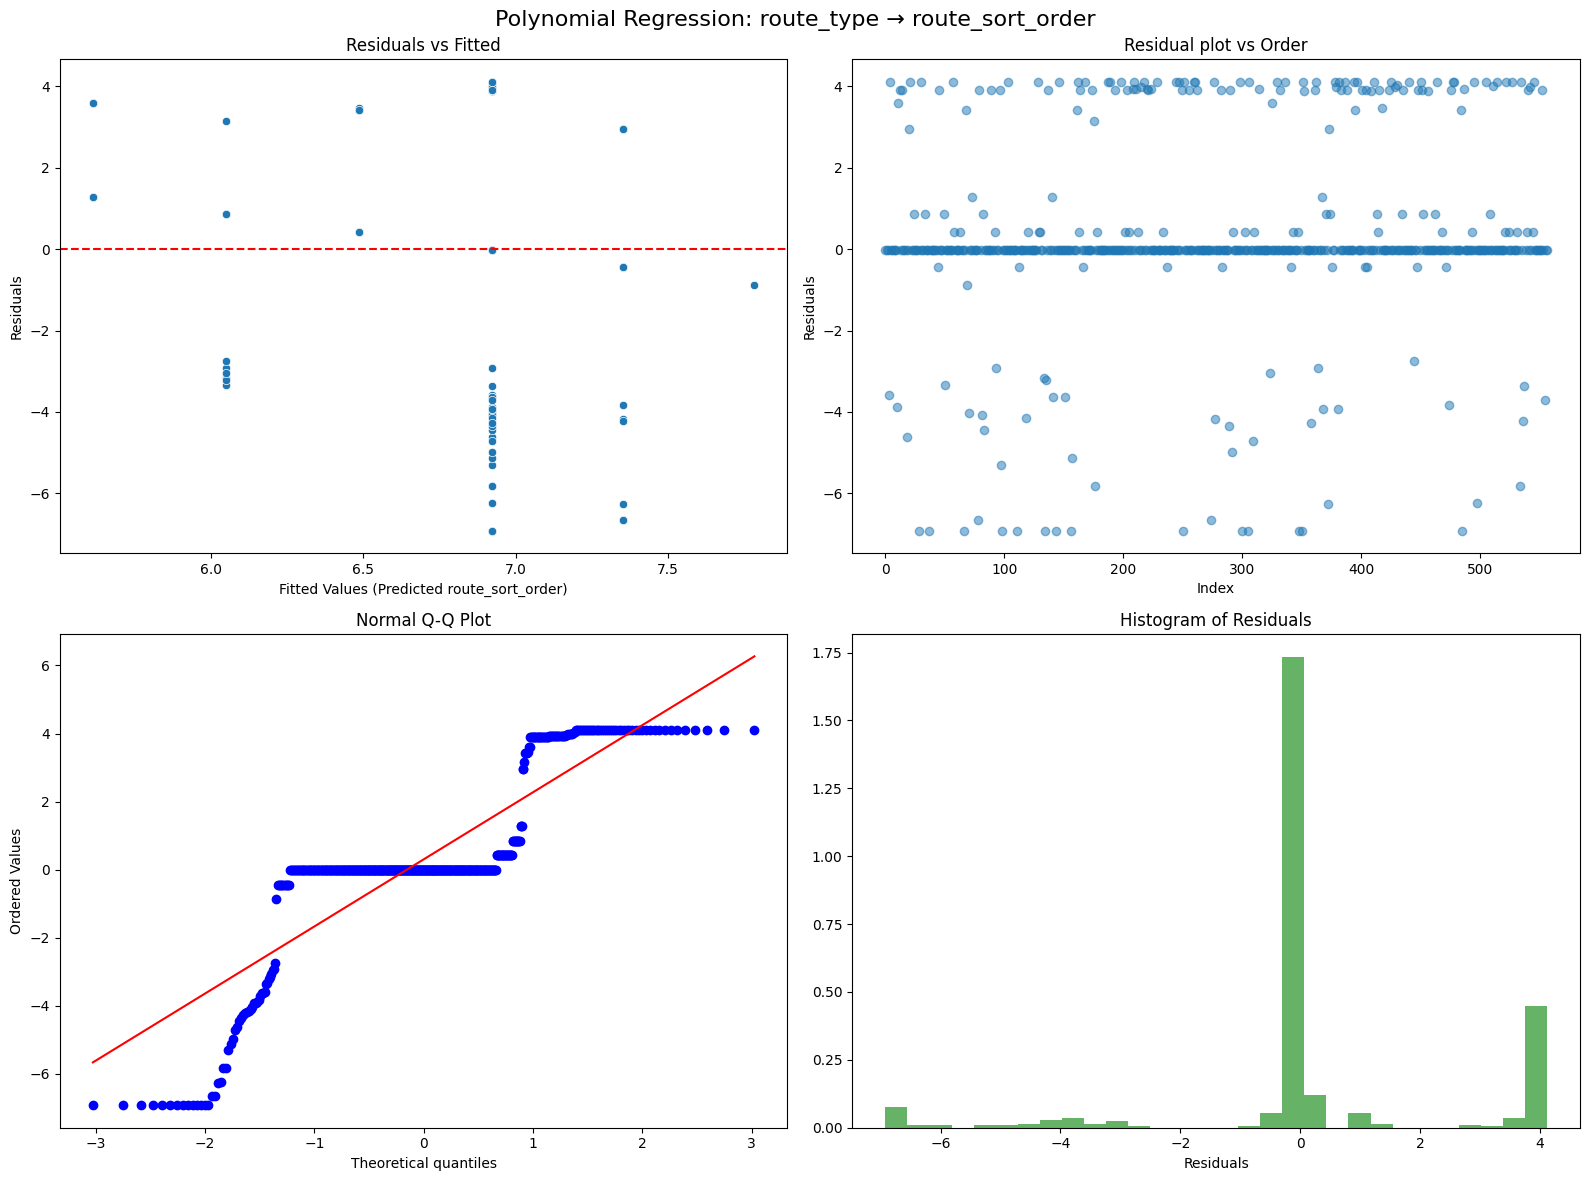

In [35]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the polynomial regression model =', model['mse'].round(3))
print('R^2 for the polynomial regression model =', round(model['r2'], 4))

# Diagnostic Plots
plt.figure(figsize=(16, 12))

# Extract predictions and residuals from your model dictionary
y_pred = model['ypreds']
residuals = model['resids']

# 1. Residuals vs Fitted (Linearity/Constant Variance)
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values (Predicted route_sort_order)')
plt.ylabel('Residuals')

# 2. Residuals vs Order
plt.subplot(2, 2, 2)
plt.scatter(range(len(Xtest)), residuals, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual plot vs Order")
    
# 3. Q-Q Plot (Normality)
plt.subplot(2, 2, 3)
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 4. Histogram of Residuals (Normality)
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

plt.suptitle('Polynomial Regression: route_type → route_sort_order', fontsize=16)
plt.tight_layout()
plt.show()

### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables


In [34]:
# Prepares the data
X_diversity = np.array(df['route_type_diversity']).reshape(-1,1)
y = df['total_routes']
X_transit_cat = df['transit_category'].astype('category').cat.codes.values.reshape(-1, 1)
X_route_type = df['route_type'].astype('category').cat.codes.values.reshape(-1, 1)

# degree 4 for the polynomial
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_diversity_poly_bias = poly.fit_transform(X_diversity)
# removes the bias column
X_diversity_poly = X_diversity_poly_bias[:, 1:]

# combines X_diversity_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_diversity_poly,
    X_transit_cat * X_route_type,
    X_transit_cat * (1 - X_route_type), 
    (1 - X_transit_cat) * X_route_type], axis=1)

print(X_poly[0])

[  5.  25. 125. 625.   0.   0.   3.]


In [35]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', model['mse'].round(3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 1048080.623
R^2 for the second poly regression model = -6.5993


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach
After some discussion, we decided to build separate Linear Regression models for three features. These features were temporal patterns, system characteristics, and geographic coverage. We also tested out a Polynomial Regression approach for one feature to see if a non-linear model might do better. Unfortunately, the Polynomial Regression gave us MSE = 627.869 and R² = 0.0035, which was worse than Linear Regression. We then tried adding interactions with dummy variables for categorical transit features to improve it. This helped a bit, bringing the values to MSE = 599.699 and R² = 0.0482, but it was still worse than the Linear Regression models. So we decided to stick with Linear Regression for our analysis.

## Model 1
First, we analyzed Model 1: Time of Day of Linear Regression model. We calculated $MSE$ = 514.094 and $R^2$ = 0.0477, where MSE value is lower than for the polynomial regression models and $R^2$ value is slightly lower than the second polynomial regression model. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is violated as the residuals do not follow a linear trend about 0 and also contain multiple outliers. The second plot of Residuals vs Order shows that there is some density of the data points near the y = 0 with mutliple outliers as well, indicating there might be a violation of Independence assumption as well. Looking at the Histogram of Residuals and Q-q plot, we can witness there is strong right-skewedness, showing that there is no normal distribution, meaning violation of Normality assumption. 

## Model 2
We analyzed a Polynomial Regression Model with a degree of 2 predicting route_sort_order from route_type using log-transformed target values, which gave us an MSE = 5.352 and R² = -0.0259, indicating the model performs worse than predicting the mean. The Residuals vs Fitted graph shows vertical clustering patterns rather than random scatter around 0, which violates the linearity and constant variance assumptions. The Q-Q Plot and Histogram of Residuals show a large departure from normality, with horizontal step patterns and three distinct peaks instead of the expected bell curve. These violations indicate that route_type isn't suitable as a predictor for route_sort_order, as transit mode does not determine route priority ordering within or across cities.

## Model 3
Model 3, which describes polynomial regression with interaction terms and dummy variables, examines whether the relationship between route-type diversity and total routes differs across the  transit categories Transit-Rich vs Transit-Limited cities. This model has polynomial terms up to degree 4, along with interaction terms between diversity and both transit category and route type. The model reported an MSE of  1,048,080.623 and R^2 of -6.5993. The extremely high MSE and negative R² indicate that this model performs significantly worse than even a naive baseline model that simply predicts the mean value for all observations. The fitting of polynomial terms up to fourth degree seems to have caused overfitting issues. This suggests that either the polynomial degree is too high for the  dataset size, the interaction terms are making conflicting results, or that the transit systems can't be accurately captured through polynomial transformations of route diversity alone.

## Conclusions
Looking at our three Linear Regression models for predicting total transit routes, the results weren't great. Model 2 performed best with MSE = 508.001 and R² = 0.059, but that R² basically means we're only explaining 6% of what determines route totals. The other 94% is still a mystery, which doesn't give us much predictive power.

None of our models actually satisfy the assumptions for linear regression. The residual plots have clear patterns instead of being randomly scattered, the variance isn't constant, and everything is skewed to the right. We tried using polynomial regression with interaction terms to fix these issues, but that made things worse. This tells us the relationship between our features and route totals is probably way more complicated than what these models can capture.

When you think about it, the poor performance makes sense. We're probably missing a lot of important factors that affect how many routes a city ends up with - things like population size, how much money the city has for transit, geographic barriers, whether the city even prioritizes public transit, and just the historical development of the system. The features we used are pretty basic and can't really account for all that.

Going forward, we'd need to try different approaches. We definitely need more features - population density, budget information, land area, maybe even political factors. We could also look at hierarchical models since cities in similar regions probably have similar transit patterns.
The main takeaway is that linear regression just isn't working for this. We need better features and probably more sophisticated models to actually predict transit route totals in a meaningful way.